# Power spectrum window matrix plots (DESI Y1)

In [1]:
import os
import sys

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker

from pypower import BaseMatrix

sys.path.append('../bin')
from desi_file_manager import DESIFileName
from local_file_manager import LocalFileName

# plotting
plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

### Global parameters

In [2]:
# official desi ('desi') or locally ('local') generated window/pk
source = 'desi'

# mocks/version
version = 'v3' # one of 'first', 'second' if source == 'local' or 'v2', 'v3' if source == 'desi'

# tracer
tracer = 'ELG'
region = 'SGC'
completeness = True

# multipoles
ells = (0, 2, 4)
ktmax = 20
krange = (0., 0.6, 0.005)

# cut
rpcut = 0
thetacut = 0.05

## Load window matrix $W(k, k^{\prime})$

In [3]:
from pypower import BaseMatrix

if source == 'desi':
    wm_fn = DESIFileName()
    wm_fn.set_default_config(version=version, ftype='wmatrix_smooth', tracer=tracer, region=region, completeness=completeness, realization='merged')
    koutrebin = 5
elif source == 'local':
    wm_fn = LocalFileName()
    wm_fn.set_default_config(mockgen=version, ftype='wmatrix_smooth', tracer=tracer, region=region, completeness=completeness, realization=None, boxsize=10000)
    wm_fn.update(cellsize=None)
    koutrebin = 1

wm = BaseMatrix.load(wm_fn.get_path(rpcut=0., thetacut=0.))
wm_cut = BaseMatrix.load(wm_fn.get_path(rpcut=rpcut, thetacut=thetacut))

kinrebin = 10
    
for w in [wm, wm_cut]:
    w.slice_x(sliceout=slice(0, len(w.xout[0]) // koutrebin * koutrebin, koutrebin))
    w.select_x(xoutlim=(krange[0], krange[1]))
    w.slice_x(slicein=slice(0, len(w.xin[0]) // kinrebin * kinrebin, kinrebin))
    w.select_x(xinlim=(0.005, ktmax))

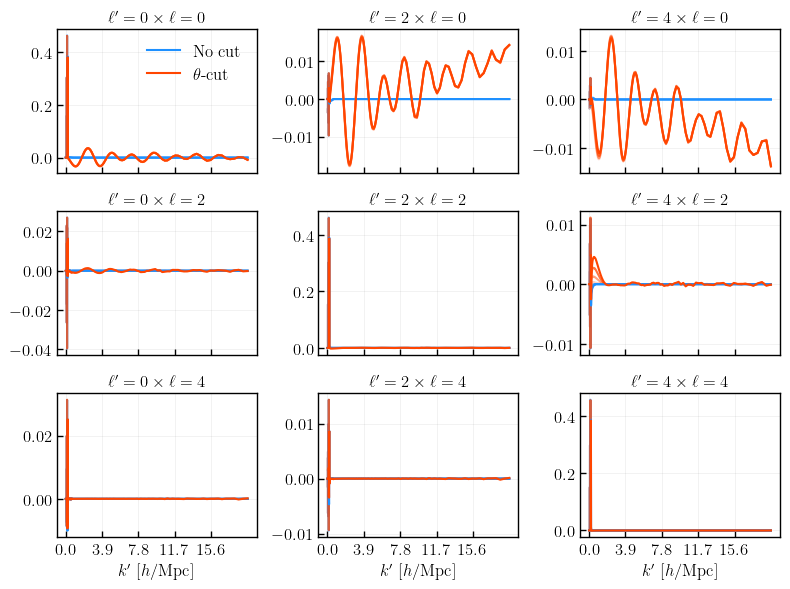

In [4]:
kobs = [0.05, 0.1, 0.15, 0.2]
alphas = [0.25, 0.5, 0.75, 1]

if rpcut:
    cutlabel = r'$r_{\perp}$-cut'
elif thetacut:
    cutlabel = r'$\theta$-cut'

fig, lax = plt.subplots(len(wm.projsout), len(wm.projsin), figsize=(8, 6), sharey=False, sharex=True)

for i in range(len(kobs)):

    indexout = np.abs(wm.xout[0] - kobs[i]).argmin()

    for iin, projin in enumerate(wm.projsin):
        for iout, projout in enumerate(wm.projsout):
            ax = lax[iout][iin]
            ax.plot(wm.xin[iin], wm.unpacked()[iin][iout][:, indexout], label=r'No cut' if i==3 else '', color='C0', alpha=alphas[i])
            ax.plot(wm_cut.xin[iin], wm_cut.unpacked()[iin][iout][:, indexout], label=cutlabel if i==3 else '', ls='-', color='C1', alpha=alphas[i])
            ax.xaxis.set_ticks(np.arange(0, min(np.max(wm.xin[iin]), ktmax), min(np.max(wm.xin[iin]), ktmax)/5))
            ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
            ax.set_title(r'$\ell^\prime = {:d} \times \ell = {:d}$'.format(projin.ell, projout.ell))
            if iout == len(wm.projsout) - 1: ax.set_xlabel(r'$k^\prime$ [$h/\mathrm{Mpc}$]')
            if i==3 and iin == iout == 0: lax[iout][iin].legend()
plt.tight_layout(pad=0.3)
plt.savefig(os.path.join(plots_dir, version, 'wmatrix_{}cut{}_{}_{}_{}_ktmax{}.pdf'.format('rp' if rpcut else 'theta', max(rpcut, thetacut), tracer, region, 'complete' if completeness else 'fa', ktmax)), dpi=200)
plt.show()

## Test with constant theory

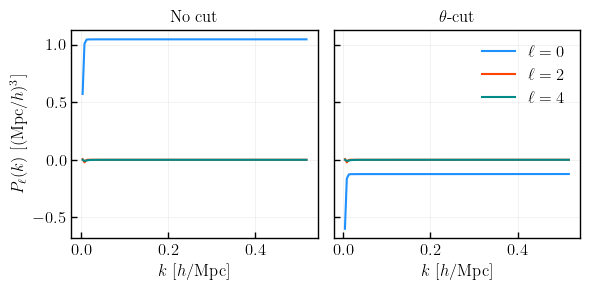

In [6]:
shotnoise_theory = np.zeros(wm.shape[0])
shotnoise_theory[:wm.shape[0]//len(ells)] = 1
pkobs = wm.value.T.dot(shotnoise_theory).reshape((len(ells), wm.shape[1]//len(ells)))
pkobs_cut = wm_cut.value.T.dot(shotnoise_theory).reshape((len(ells), wm_cut.shape[1]//len(ells)))

fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True, sharex=True)

for ill, ell in enumerate([0, 2, 4]):
    axes[0].plot(wm.xout[ill], pkobs[ill], color='C{}'.format(ill))
    axes[1].plot(wm_cut.xout[ill], pkobs_cut[ill], color='C{}'.format(ill), label=r'$\ell = {}$'.format(ell))
axes[0].set_ylabel(r'$P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
axes[0].set_title(r'No cut')
axes[1].set_title(cutlabel)
axes[0].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
axes[1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
axes[1].legend()
#plt.savefig(os.path.join(plots_dir, 'wmatrix_csttheory_rpcut_directedges_ktmax20.png'), dpi=300)
plt.show()